[*********************100%***********************]  5 of 5 completed


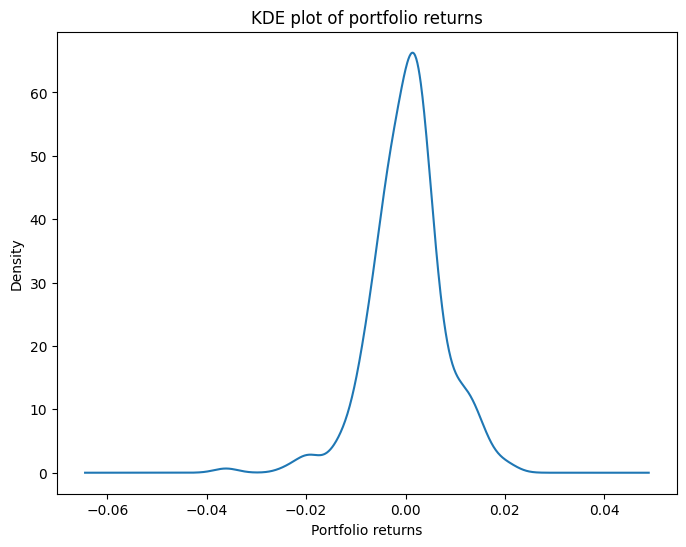

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm


# Get data
start = '2016-01-01'
end = '2016-12-31'
etfs = ['QQQ', 'SPY', 'IWM', 'EFA', 'TLT']

data = yf.download(tickers=etfs, start=start, end=end)['Close']

# returns
ret_data = np.log(data / data.shift(1)).dropna()

# portfolio returns
weights = np.array([1/len(etfs) for _ in etfs])
portfolio_returns = ret_data.dot(weights)

# plot
plt.figure(figsize=(8, 6))
portfolio_returns.plot(kind='density')
plt.title('KDE plot of portfolio returns')
plt.xlabel('Portfolio returns')
plt.show()


Assume we have 1,000,000$

1 day PnL

Cumulative Return: 0.0735
PnL for the period: 73541.51


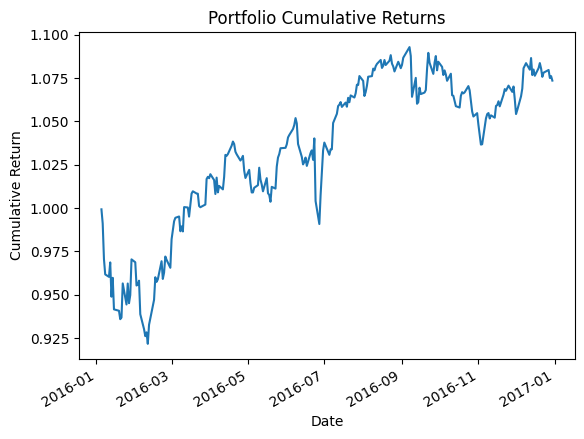

In [2]:
# Calculate cumulative return
cumulative_return = portfolio_returns.cumsum().iloc[-1]

# Calculate 1 day PnL
initial_investment = 1_000_000
pnl = initial_investment * (cumulative_return + 1) - initial_investment

print(f"Cumulative Return: {cumulative_return:.4f}")
print(f"PnL for the period: {pnl:.2f}")

# Plot cumulative returns over time
(portfolio_returns.cumsum() + 1).plot()
plt.title('Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [3]:
import warnings
warnings.filterwarnings('ignore')

1-day 5% Historical VaR and CVaR

Historical 5% VaR (in value for 1,000,000 investment): 10759.57
Historical 5% VaR (in returns): 0.0108
Historical 5% CVaR (in value for 1,000,000 investment): 17441.95
5% Historical CVaR (in returns): 0.0174


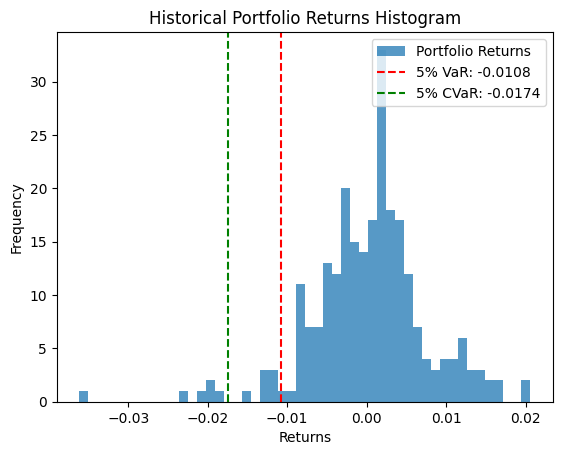

In [4]:
# Historical Method Calculate 5% VaR
historical_var_5_percent = -np.percentile(portfolio_returns, 5)
var_5_percent_value = 1_000_000 * historical_var_5_percent
print(f"Historical 5% VaR (in value for 1,000,000 investment): {var_5_percent_value:.2f}")
print(f"Historical 5% VaR (in returns): {historical_var_5_percent:.4f}")

# Calculate 5% CVaR using historical simulation
losses_below_var = portfolio_returns[portfolio_returns <= -historical_var_5_percent]
cvar_historical = -np.mean(losses_below_var)
cvar_5_percent_value = 1_000_000 * cvar_historical
print(f"Historical 5% CVaR (in value for 1,000,000 investment): {cvar_5_percent_value:.2f}")
print(f"5% Historical CVaR (in returns): {cvar_historical:.4f}")


# Plot histogram of portfolio returns
plt.hist(portfolio_returns, bins=50, alpha=0.75,label="Portfolio Returns")
plt.axvline(x=-historical_var_5_percent, color='r', linestyle='--', label=f'5% VaR: {-historical_var_5_percent:.4f}')
plt.axvline(x=-cvar_historical, color='g', linestyle='--', label=f'5% CVaR: {-cvar_historical:.4f}')
plt.title('Historical Portfolio Returns Histogram')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

1-day Variance-Covariance VaR

Variance-Covariance 5% VaR (in returns): 0.0116
Variance-Covariance 5% VaR (in value for 1,000,000 investment): 10759.57
5% Variance-Covariance CVaR (in returns): 0.0152
Variance-Covariance 5% CVaR (in value for 1,000,000 investment): 15227.29


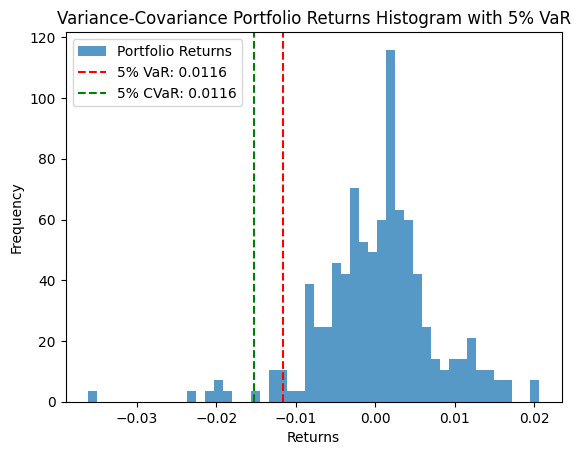

In [5]:
# Calculate mean returns and covariance matrix
mean_returns = ret_data.mean()
cov_matrix = ret_data.cov()

# Portfolio expected return and standard deviation
portfolio_expected_return = np.dot(weights, mean_returns)
portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Calculate 1-day 5% VaR using variance-covariance method
confidence_level = 0.05
z_score = norm.ppf(confidence_level)
VCvar_5_percent = -(portfolio_expected_return + z_score * portfolio_std_dev)
VCvar_5_percent_value = 1_000_000 * VCvar_5_percent

print(f"Variance-Covariance 5% VaR (in returns): {VCvar_5_percent:.4f}")
print(f"Variance-Covariance 5% VaR (in value for 1,000,000 investment): {var_5_percent_value:.2f}")

# Calculate 5% CVaR using variance-covariance method
alpha = 0.05
phi = norm.pdf(norm.ppf(alpha))
cvar_variance_covariance = (portfolio_expected_return + (phi / alpha) * portfolio_std_dev)
cvar_5_percent_value = 1_000_000 * cvar_variance_covariance 
print(f"5% Variance-Covariance CVaR (in returns): {cvar_variance_covariance:.4f}")
print(f"Variance-Covariance 5% CVaR (in value for 1,000,000 investment): {cvar_5_percent_value:.2f}")

# Plot histogram of portfolio returns
portfolio_returns = ret_data.dot(weights)
plt.hist(portfolio_returns, bins=50, alpha=0.75, label="Portfolio Returns", density=True)
plt.axvline(x=-VCvar_5_percent, color='r', linestyle='--', label=f'5% VaR: {VCvar_5_percent:.4f}')
plt.axvline(x=-cvar_variance_covariance, color='g', linestyle='--', label=f'5% CVaR: {VCvar_5_percent:.4f}')
plt.title('Variance-Covariance Portfolio Returns Histogram with 5% VaR')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

1-day Monte Carlo VaR

Monte Carlo 5% VaR (in returns): 0.0116
Monte Carlo 5% VaR (in value for 1,000,000 investment): 11615.28
Monte Carlo 5% CVaR (in returns): 0.0146
Monte Carlo 5% CVaR (in value for 1,000,000 investment): 14611.69


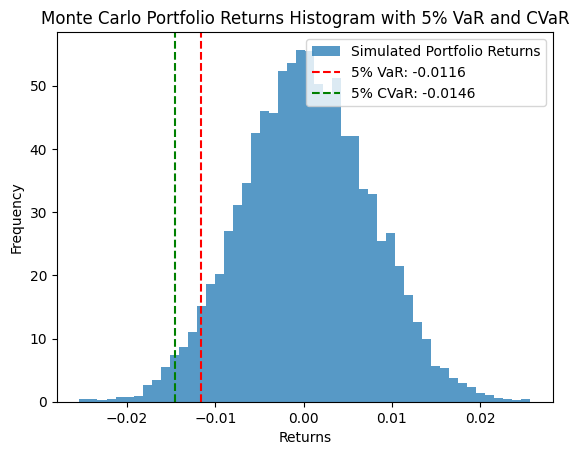

In [6]:
# Monte Carlo simulation
num_simulations = 10000
simulated_returns = np.zeros(num_simulations)

for i in range(num_simulations):
    random_returns = np.random.multivariate_normal(mean_returns, cov_matrix)
    portfolio_return = np.dot(weights, random_returns)
    simulated_returns[i] = portfolio_return

# Calculate 5% VaR from simulations
MCvar_5_percent = -np.percentile(simulated_returns, 5)
MCvar_5_percent_value = 1_000_000 * MCvar_5_percent

# Calculate 5% CVaR from simulations
worst_5_percent = np.percentile(simulated_returns, 5)
losses_in_worst_5_percent = simulated_returns[simulated_returns <= worst_5_percent]
MCcvar_5_percent = -np.mean(losses_in_worst_5_percent)
MCcvar_5_percent_value = 1_000_000 * MCcvar_5_percent

print(f"Monte Carlo 5% VaR (in returns): {MCvar_5_percent:.4f}")
print(f"Monte Carlo 5% VaR (in value for 1,000,000 investment): {MCvar_5_percent_value:.2f}")

print(f"Monte Carlo 5% CVaR (in returns): {MCcvar_5_percent:.4f}")
print(f"Monte Carlo 5% CVaR (in value for 1,000,000 investment): {MCcvar_5_percent_value:.2f}")

# Plot histogram of simulated portfolio returns
plt.hist(simulated_returns, bins=50, alpha=0.75, label="Simulated Portfolio Returns", density=True)
plt.axvline(x=-MCvar_5_percent, color='r', linestyle='--', label=f'5% VaR: {-MCvar_5_percent:.4f}')
plt.axvline(x=-MCcvar_5_percent, color='g', linestyle='--', label=f'5% CVaR: {-MCcvar_5_percent:.4f}')

plt.title('Monte Carlo Portfolio Returns Histogram with 5% VaR and CVaR')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()


1-day 5% t-Copula VaR

In [7]:
from scipy.stats import t
from copulas.univariate import GaussianKDE
from copulas.multivariate import GaussianMultivariate
import numpy as np
import pandas as pd

def t_copula_var(ret_data, weights, initial_investment=1_000_000, alpha=0.05, num_samples=1000):
    # 1. Fit t-distributions to each asset
    params = []
    for col in ret_data.columns:
        dof, loc, scale = t.fit(ret_data[col].values)
        params.append((dof, loc, scale))

    # 2. Transform data using t CDF
    uniform_data = pd.DataFrame(columns=ret_data.columns)
    for col, param in zip(ret_data.columns, params):
        uniform_data[col] = t.cdf(ret_data[col].values, df=param[0], loc=param[1], scale=param[2])

    # 3. Fit the Gaussian copula to the transformed data
    copula = GaussianMultivariate()
    copula.fit(uniform_data)

    # 4. Simulate from the t-copula
    simulated_data = copula.sample(num_samples)

    # 5. Convert simulated copula data back to original space
    simulated_returns = pd.DataFrame(columns=ret_data.columns)
    for col, param in zip(ret_data.columns, params):
        simulated_returns[col] = t.ppf(simulated_data[col].values, df=param[0], loc=param[1], scale=param[2])

    # Calculate simulated portfolio returns
    simulated_port_returns = np.dot(simulated_returns.values, weights)

    # Convert returns to loss in value
    simulated_port_loss = initial_investment * simulated_port_returns

    # Calculate VaR in terms of loss in value
    VaR_t_copula_value = -np.percentile(simulated_port_loss, alpha*100)
    VaR_t_copula_percentage = -np.percentile(simulated_port_returns, alpha*100)

    # Calculate CVaR in terms of loss in value and percentage
    losses_below_VaR = simulated_port_loss[simulated_port_loss <= -VaR_t_copula_value]
    CVaR_t_copula_value = -np.mean(losses_below_VaR)
    
    returns_below_VaR = simulated_port_returns[simulated_port_returns <= -VaR_t_copula_percentage]
    CVaR_t_copula_percentage = -np.mean(returns_below_VaR)


    return VaR_t_copula_value,VaR_t_copula_percentage, CVaR_t_copula_value, CVaR_t_copula_percentage


VaR_result_tcopula, VaR_t_copula_percentage,CVaR_t_copula_value, CVaR_t_copula_percentage= t_copula_var(ret_data, weights)
print(f"Monte Carlo 5% VaR (in returns): {VaR_t_copula_percentage:.4f}")
print('t-copula VaR in terms of loss in value for 1,000,000 investment:', VaR_result_tcopula)
print('t-copula CVaR in returns:',CVaR_t_copula_percentage )
print('t-copula CVaR in terms of loss in value for 1,000,000 investment:', CVaR_t_copula_value)


Monte Carlo 5% VaR (in returns): 0.0096
t-copula VaR in terms of loss in value for 1,000,000 investment: 9599.166321972907
t-copula CVaR in returns: 0.013696480423312753
t-copula CVaR in terms of loss in value for 1,000,000 investment: 13696.480423312756


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [10]:
# Define the models
class Generator(nn.Module):
    def __init__(self, num_encoding,num_hidden, num_inputs):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_encoding, num_hidden),
            nn.ELU(),
            nn.BatchNorm1d(num_hidden),
            nn.Linear(num_hidden, num_encoding),
            nn.ELU(),
            nn.Linear(num_encoding,num_inputs)

        )

    def forward(self, z):
        output = self.model(z)
        #output = torch.tanh(output) 
        return output
        
class Discriminator(nn.Module):
    def __init__(self, num_hidden):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(15, num_hidden),  # nn.Linear(num_inputs + num_encoding, num_hidden)，x=10
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(num_hidden, 1),
            nn.Sigmoid()
        )

    def forward(self, x, z):
        return self.model(torch.cat((x, z), dim=1))


class Encoder(nn.Module):
    def __init__(self,num_inputs , num_hidden, num_encoding):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(num_hidden),
            nn.Linear(num_hidden, num_encoding),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [11]:
ret_data.shape[1] 

5

In [129]:
# Hyperparameters & Initialization
ret_data_tensor = torch.Tensor(ret_data.values)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_inputs = ret_data.shape[1] #x
num_hidden = 100
num_encoding = 10 #z
batch_size = 100
learning_rate = 0.0001
num_epochs = 4000

generator = Generator(num_encoding=num_encoding, num_hidden=num_hidden, num_inputs=num_inputs).to(device)
discriminator = Discriminator(num_hidden=num_hidden).to(device)
encoder = Encoder(num_inputs=num_inputs, num_hidden=num_hidden, num_encoding=num_encoding).to(device)

criterion = nn.BCELoss()
optimizer_disc = optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_enc_gen = optim.Adam(list(encoder.parameters()) + list(generator.parameters()), lr=learning_rate)

# DataLoader preparation
dataset = TensorDataset(ret_data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [130]:
# Training loop
for epoch in range(num_epochs):
    for x_batch, in dataloader:
        x_batch = x_batch.to(device)

        # Discriminator
        optimizer_disc.zero_grad()
        z_real = encoder(x_batch)
        z_fake = torch.rand((x_batch.size(0), num_encoding)).to(device)
        gen_data = generator(z_fake)

        real_labels = torch.ones(x_batch.size(0), 1).to(device)

        fake_labels = torch.zeros(x_batch.size(0), 1).to(device)

        logits_real = discriminator(x_batch, z_real)
        logits_fake = discriminator(gen_data, z_fake)
        loss_real = criterion(logits_real, real_labels)
        loss_fake = criterion(logits_fake, fake_labels)
        d_loss = (loss_real + loss_fake) / 2

        d_loss.backward()
        optimizer_disc.step()

        # Encoder & Generator
        optimizer_enc_gen.zero_grad()

        z_real = encoder(x_batch)
        z_fake = torch.rand((x_batch.size(0), num_encoding)).to(device)
        gen_data = generator(z_fake)

        logits_real = discriminator(gen_data, z_fake)
        logits_fake = discriminator(x_batch, z_real)
        g_loss = criterion(logits_real, real_labels)
        e_loss = criterion(logits_fake, fake_labels)

        g_e_loss = g_loss + e_loss
        g_e_loss.backward()
        optimizer_enc_gen.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] D Loss: {d_loss.item()} E Loss: {e_loss.item()} G Loss: {g_loss.item()}")

Epoch [1000/4000] D Loss: 0.6952186226844788 E Loss: 0.6904765963554382 G Loss: 0.7100310325622559
Epoch [2000/4000] D Loss: 0.6877358555793762 E Loss: 0.6951605677604675 G Loss: 0.6956851482391357
Epoch [3000/4000] D Loss: 0.6866631507873535 E Loss: 0.6963699460029602 G Loss: 0.7010295987129211
Epoch [4000/4000] D Loss: 0.689208984375 E Loss: 0.7007319331169128 G Loss: 0.7047193646430969


In [131]:
def generate_samples(generator, num_samples, device, num_encoding):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        samples = [
            generator(
                torch.tensor([np.random.uniform(-1.0, 1.0, size=(num_encoding))], device=device, dtype=torch.float32)
            )[0].cpu().numpy()
            for _ in range(num_samples)
        ]
    generator.train()  # Set the generator back to training mode (optional, but good practice)
    return np.array(samples)


In [132]:
simulated_returns = generate_samples(generator, 2000, device, num_encoding)
simulated_returns

array([[-0.04819211, -0.02480398, -0.05249381,  0.01757446, -0.00708263],
       [-0.01276956,  0.0848781 ,  0.11486982, -0.00383522, -0.05750988],
       [ 0.06830746, -0.00556856,  0.03963953,  0.05681954, -0.05664317],
       ...,
       [ 0.00236465, -0.15220366,  0.18864362,  0.02624702, -0.06731485],
       [-0.10862896,  0.08385661,  0.11669327,  0.0200238 , -0.11459957],
       [-0.03743402,  0.1063496 ,  0.20178299,  0.0018481 , -0.21058394]],
      dtype=float32)

<Axes: ylabel='Density'>

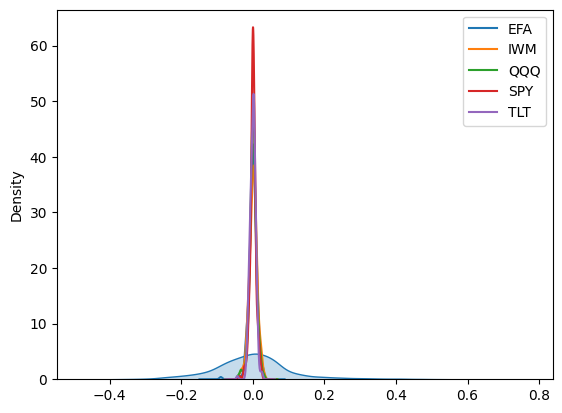

In [133]:
ret_data.plot(kind='density')
sns.kdeplot(simulated_returns.flatten(), label="Simulated Samples", shade=True)

<Axes: ylabel='Density'>

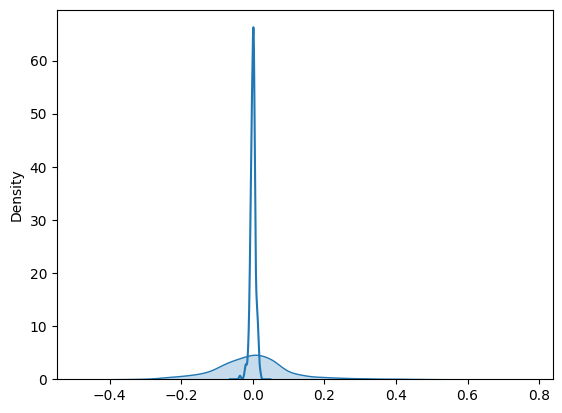

In [134]:
import seaborn as sns

sns.kdeplot(simulated_returns.flatten(), label="Simulated Samples", shade=True)
port_data['Portfolio.ret'].plot(kind='density')

In [135]:
def train(generator, discriminator, encoder, dataloader, num_epochs, device, criterion, optimizer_disc, optimizer_enc_gen, num_encoding):
    for epoch in range(num_epochs):
        for x_batch, in dataloader:
            x_batch = x_batch.to(device)

            # Discriminator
            optimizer_disc.zero_grad()
            z_real = encoder(x_batch)
            z_fake = torch.rand((x_batch.size(0), num_encoding)).to(device)
            gen_data = generator(z_fake)

            real_labels = torch.ones(x_batch.size(0), 1).to(device)
            fake_labels = torch.zeros(x_batch.size(0), 1).to(device)

            logits_real = discriminator(x_batch, z_real)
            logits_fake = discriminator(gen_data, z_fake)
            loss_real = criterion(logits_real, real_labels)
            loss_fake = criterion(logits_fake, fake_labels)
            d_loss = (loss_real + loss_fake) / 2

            d_loss.backward()
            optimizer_disc.step()

            # Encoder & Generator
            optimizer_enc_gen.zero_grad()

            z_real = encoder(x_batch)
            z_fake = torch.rand((x_batch.size(0), num_encoding)).to(device)
            gen_data = generator(z_fake)

            logits_real = discriminator(gen_data, z_fake)
            logits_fake = discriminator(x_batch, z_real)
            g_loss = criterion(logits_real, real_labels)
            e_loss = criterion(logits_fake, fake_labels)

            g_e_loss = g_loss + e_loss
            g_e_loss.backward()
            optimizer_enc_gen.step()

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] D Loss: {d_loss.item()} E Loss: {e_loss.item()} G Loss: {g_loss.item()}")


In [136]:
# Train the models
train(generator, discriminator, encoder, dataloader, num_epochs, device, criterion, optimizer_disc, optimizer_enc_gen, num_encoding)

# Generate samples after training
simulated_returns_trained = generate_samples(generator, 20000, device, num_encoding)
print(simulated_returns_trained)


Epoch [1000/4000] D Loss: 0.6943700313568115 E Loss: 0.6994826197624207 G Loss: 0.6905653476715088
Epoch [2000/4000] D Loss: 0.6906838417053223 E Loss: 0.7030314803123474 G Loss: 0.7000200152397156
Epoch [3000/4000] D Loss: 0.690711498260498 E Loss: 0.7033430933952332 G Loss: 0.7214577794075012
Epoch [4000/4000] D Loss: 0.6839993000030518 E Loss: 0.6987007260322571 G Loss: 0.6942842602729797
[[ 0.02082694 -0.07334547  0.06675391 -0.03553457 -0.06870714]
 [-0.04570947  0.06106162  0.08915202 -0.02287736 -0.00314234]
 [-0.00419642 -0.01522268  0.06209846 -0.04342626 -0.07075787]
 ...
 [ 0.06283817  0.03584081  0.07042633 -0.06229068 -0.11744335]
 [-0.00329496 -0.03482991 -0.00744817 -0.05261848  0.06562525]
 [-0.01512621  0.02922633  0.03280795 -0.04215328 -0.05815729]]


<Axes: ylabel='Density'>

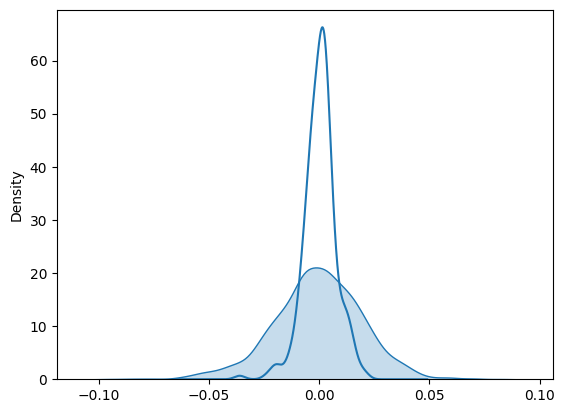

In [142]:
port_simulated_returns = np.dot(simulated_returns, weights)
sns.kdeplot(port_simulated_returns.flatten(), label="Simulated Samples", shade=True)
port_data['Portfolio.ret'].plot(kind='density')

<Axes: ylabel='Density'>

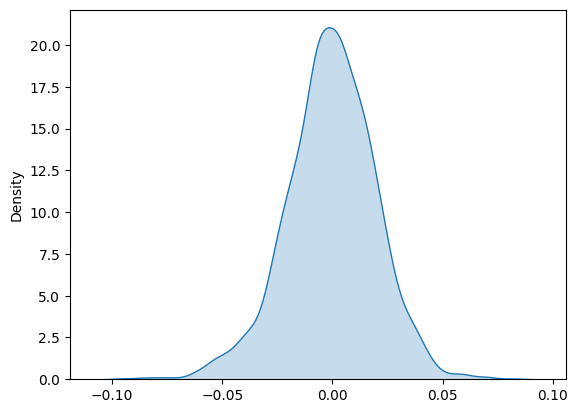

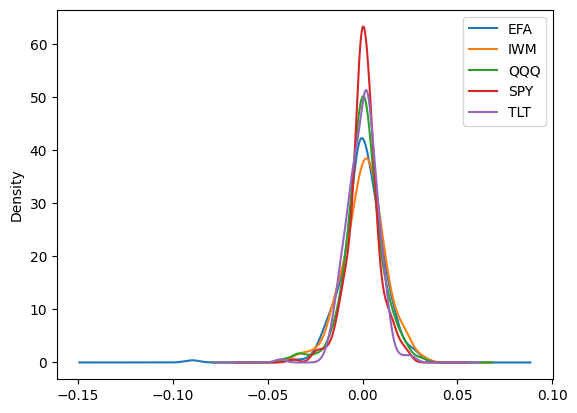

In [143]:
sns.kdeplot(port_simulated_returns.flatten(), label="Simulated Samples", shade=True)
ret_data.plot(kind='density')

<Axes: ylabel='Density'>

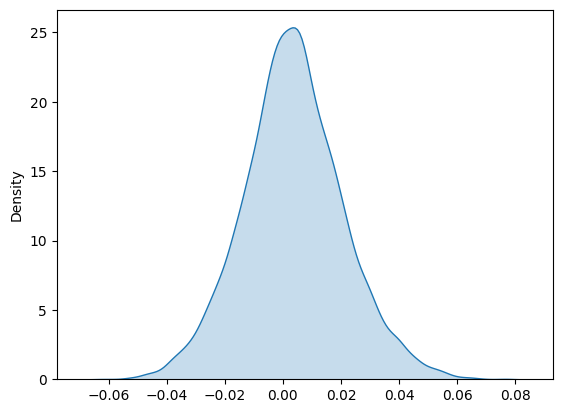

In [144]:
port_simulated_returns_trained=np.dot(simulated_returns_trained, weights)
sns.kdeplot(port_simulated_returns_trained.flatten(), label="Simulated Samples", shade=True)

<Axes: ylabel='Density'>

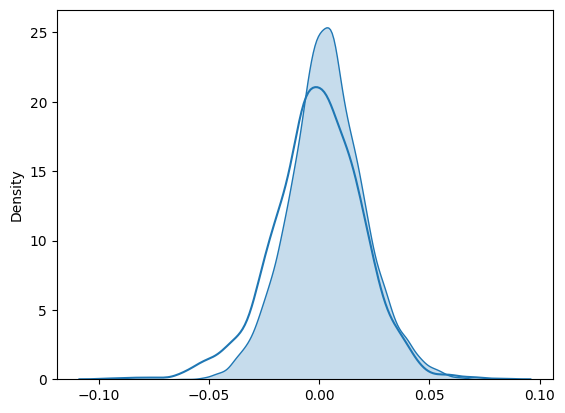

In [146]:
sns.kdeplot(port_simulated_returns_trained.flatten(), label="Simulated Samples", shade=True)
sns.kdeplot(port_simulated_returns.flatten(), label="Simulated Samples", shade=False)

In [147]:
calculate_var(port_simulated_returns)

0.043608866900205615

In [148]:
calculate_var(port_simulated_returns_trained)

0.04708156656473872